In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import joblib

In [2]:
df = pd.read_csv(r'C:\Users\Kerry\Stroke Prediction\data\healthcare-dataset-stroke-data.csv')
print("Shape:", df.shape)

Shape: (5110, 12)


In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
print("Class distribution:\n", df['stroke'].value_counts(normalize=True))

Class distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


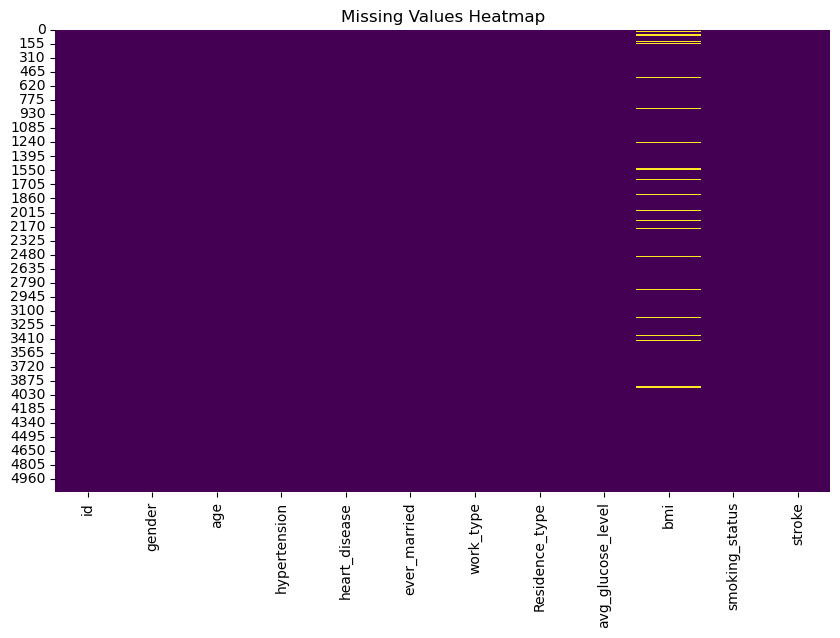

In [8]:
# Heatmap of missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

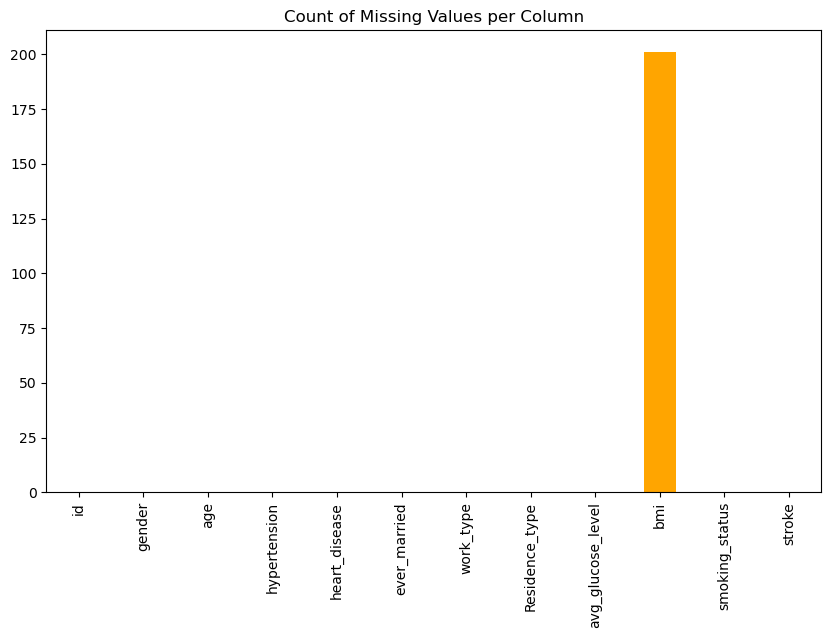

In [9]:
# Bar plot of missing values count
df.isnull().sum().plot(kind="bar", figsize=(10,6), color="orange")
plt.title("Count of Missing Values per Column")
plt.show()

C:\Users\Kerry\AppData\Local\Temp\ipykernel_15884\1427908331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="stroke", data=df, palette="Set2")


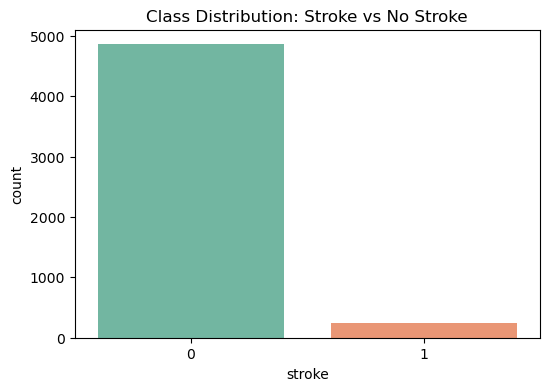

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="stroke", data=df, palette="Set2")
plt.title("Class Distribution: Stroke vs No Stroke")
plt.show()

print(df["stroke"].value_counts(normalize=True))

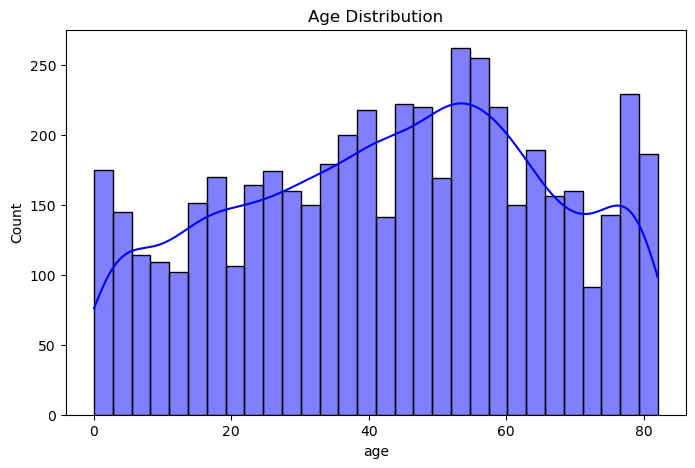

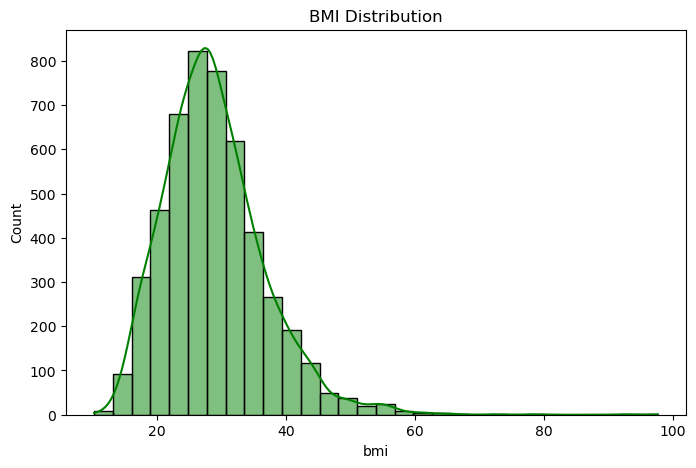

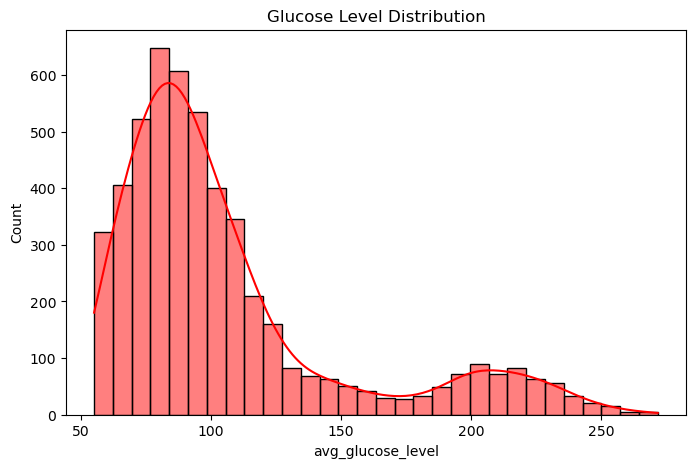

In [11]:
# Age distribution
plt.figure(figsize=(8,5))
sns.histplot(df["age"], bins=30, kde=True, color="blue")
plt.title("Age Distribution")
plt.show()

# BMI distribution (with missing handled)
plt.figure(figsize=(8,5))
sns.histplot(df["bmi"].dropna(), bins=30, kde=True, color="green")
plt.title("BMI Distribution")
plt.show()

# Avg Glucose Levels
plt.figure(figsize=(8,5))
sns.histplot(df["avg_glucose_level"], bins=30, kde=True, color="red")
plt.title("Glucose Level Distribution")
plt.show()

### Separating features and targets

In [12]:
y = df["stroke"]
X = df.drop(columns=["stroke", "id"]) 

### Identifying numeric and categorical values

In [13]:
num_cols = ["age", "avg_glucose_level", "bmi"]
cat_cols = [c for c in X.columns if c not in num_cols]

C:\Users\Kerry\AppData\Local\Temp\ipykernel_15884\1424873248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="smoking_status", data=df, palette="coolwarm")


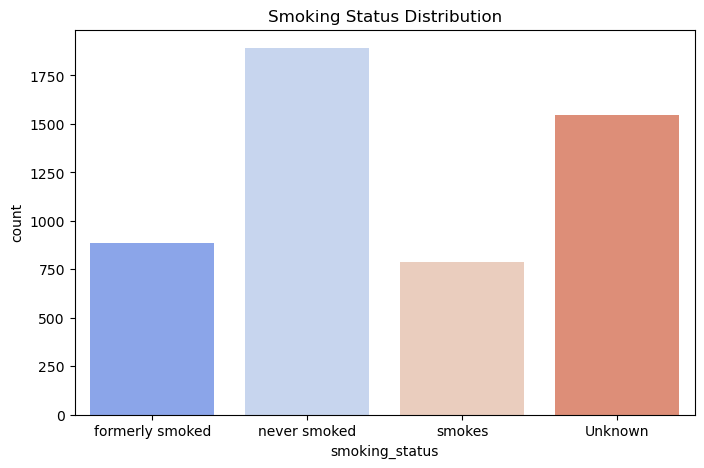

C:\Users\Kerry\AppData\Local\Temp\ipykernel_15884\1424873248.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="work_type", data=df, palette="muted")


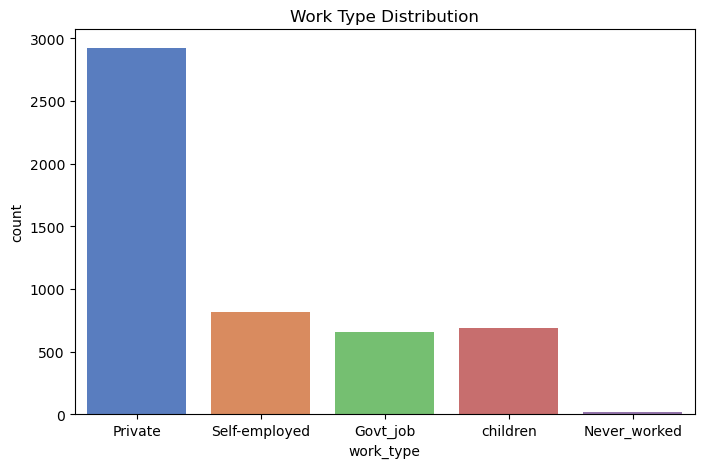

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x="smoking_status", data=df, palette="coolwarm")
plt.title("Smoking Status Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="work_type", data=df, palette="muted")
plt.title("Work Type Distribution")
plt.show()


### Preprocessing

In [15]:
numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])

### Split train/test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Models

In [17]:
models = {
    "log_reg": LogisticRegression(max_iter=500, class_weight="balanced"),
    "rf": RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42),
    "xgb": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5,
        scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
        eval_metric="logloss", random_state=42
    )
}

results = {}
best_model = None
best_auc = 0

for name, clf in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
    
    # Cross-validated AUC
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    print(f"{name} CV AUC: {auc:.3f}")
    
    # Train on full training set
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    
    # Metrics
    auc_test = roc_auc_score(y_test, proba)
    f1 = f1_score(y_test, pred)
    acc = accuracy_score(y_test, pred)
    print(f"{name} Test AUC={auc_test:.3f}, Acc={acc:.3f}, F1={f1:.3f}")
    
    results[name] = (pipe, auc_test)
    if auc_test > best_auc:
        best_auc, best_model = auc_test, pipe


log_reg CV AUC: 0.839
log_reg Test AUC=0.844, Acc=0.747, F1=0.236
rf CV AUC: 0.804
rf Test AUC=0.783, Acc=0.950, F1=0.000
xgb CV AUC: 0.817
xgb Test AUC=0.800, Acc=0.910, F1=0.258


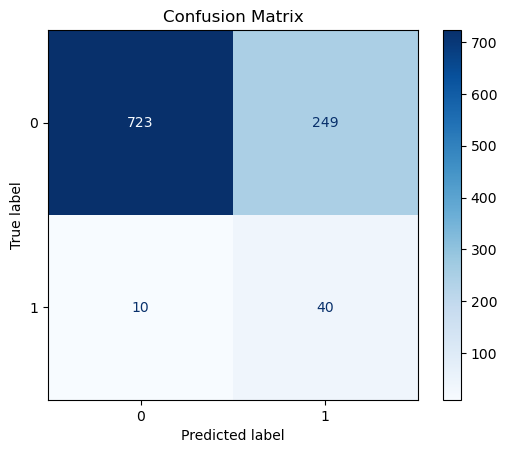

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


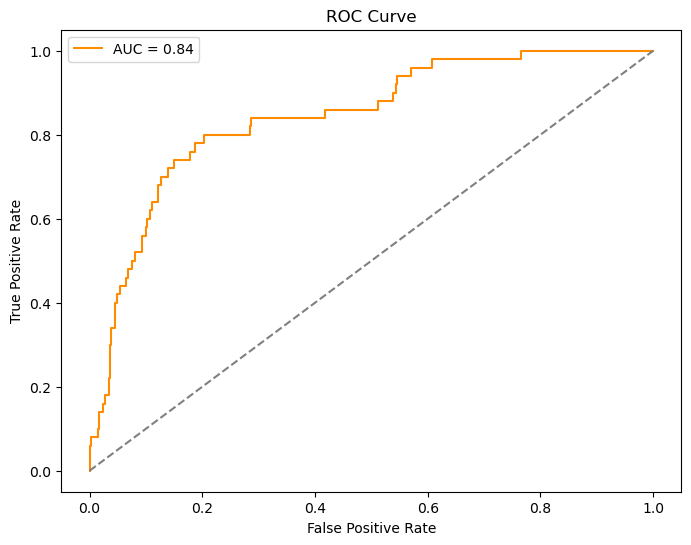

In [19]:
from sklearn.metrics import roc_curve, auc

y_prob = best_model.predict_proba(X_test)[:,1]  # probability of stroke
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


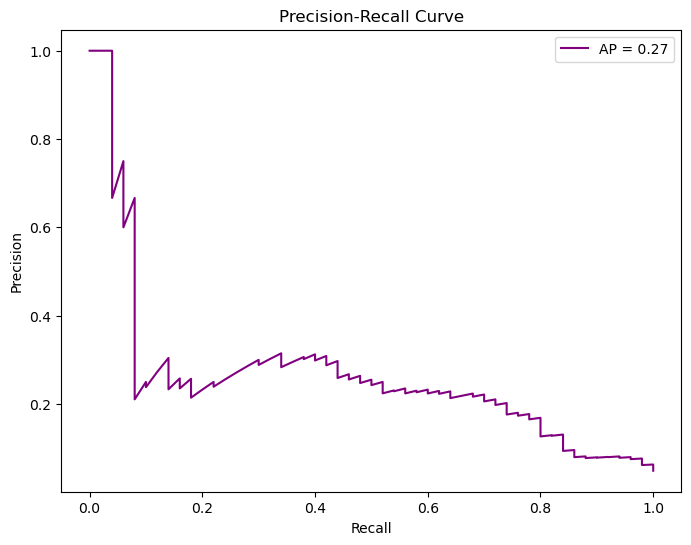

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color="purple", label=f"AP = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


### Calibration

In [21]:
clf = best_model.named_steps["clf"]
cal = CalibratedClassifierCV(clf, method="isotonic", cv=3)
calibrated = Pipeline([("pre", preprocessor), ("cal", cal)])
calibrated.fit(X_train, y_train)

proba_cal = calibrated.predict_proba(X_test)[:,1]
print("Calibrated AUC:", roc_auc_score(y_test, proba_cal))

Calibrated AUC: 0.8384979423868313


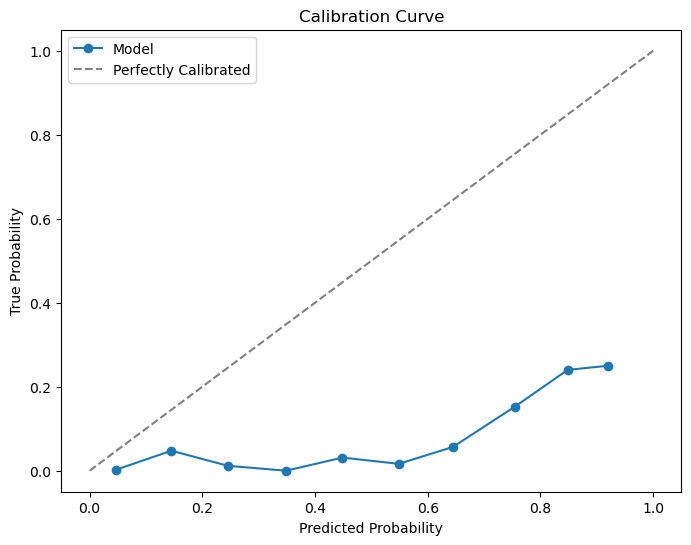

In [22]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()


### Saving the pipeline

In [25]:
import joblib

# Save each trained pipeline in the results dict
for name, (pipe, auc) in results.items():
    filename = f"models/stroke_{name}.pkl"
    joblib.dump(pipe, filename)
    print(f"✅ Saved {name} model → {filename}")

# Save the best model separately
joblib.dump(best_model, "models/stroke_best.pkl")
print("🌟 Best model saved as 'models/stroke_best.pkl'")


✅ Saved log_reg model → models/stroke_log_reg.pkl
✅ Saved rf model → models/stroke_rf.pkl
✅ Saved xgb model → models/stroke_xgb.pkl
🌟 Best model saved as 'models/stroke_best.pkl'
